# 2. Physics Informed Neural Networks

Poisson equation with unknown forcing field

We will solve the Poisson equation :
$$
u_{xx} = q(x), \quad \text{ for } x \in [-1,1]
$$
with the Dirichlet boundary conditions:
$$
u(-1) = 0, \quad u(1) = 0.
$$
Here, we assume both the solution $u(x)$ and the forcing term $q(x)$ are unknown. Instead, we assume that we are given a set of supervised observations $\{(x_i, u_i)\}_{i=1}^{100}$.
    
The reference solution is $u(x)=\sin(\pi x)$

# Dataset generation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
N = 1000                                                 # Number of samples
x = torch.linspace(-1, 1, N).view(-1,1)                  # Input data (N x 1)
x_bdry = torch.FloatTensor([[-1],[1]])                   # Input data the initial conditions (1 x 1)
u_bdry = torch.zeros_like(x_bdry)                        # Target data the initial conditions (1 x 2)
x_obs = torch.linspace(-1, 1, 100).view(-1,1)            # Input data (N x 1)
u_obs = torch.sin(np.pi*x_obs)

# Neural Network

In [ ]:
# Build a neural network

class model(nn.Module) :
    def __init__(self, hidden_dims) :                    # Hidden_dims : [h1, h2, h3, ..., hn]
        super(model, self).__init__()

        self.layers = []
        for i in range(len(hidden_dims)-1) :
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
        self.layers = nn.ModuleList(self.layers)

        for layer in self.layers :                       # Weight initialization
            nn.init.xavier_uniform_(layer.weight)        # Also known as Glorot initialization

        self.act = nn.Tanh()                             # Nonlinear activation function

    def forward(self, x) :
        for layer in self.layers[:-1] :
            x = self.act(layer(x))
        x = self.layers[-1](x)
        return x

# Loss function, Optimizer, Additional Parameters

In [ ]:
# Prepare for training
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

network_u = model(hidden_dims=[1,64,64,64,64,1]).to(device)   # Pass the network to GPU
network_q = model(hidden_dims=[1,64,64,64,64,1]).to(device)

##### Fill your own q(x) with NN, name network_q = .....
x = x.to(device).requires_grad_(True)                 # Pass data to GPU
x_bdry = x_bdry.to(device)                            # Pass data to GPU
u_bdry = u_bdry.to(device)                            # Pass data to GPU
x_obs = x_obs.to(device).requires_grad_(True)          # Pass data to GPU and enable gradient tracking
u_obs = u_obs.to(device)                              # Pass data to GPU

loss_f = nn.MSELoss()                                             # Mean Square Error loss function
optimizer = optim.Adam([
    {'params': network_u.parameters()},
    {'params': network_q.parameters()}
], lr=1e-4)           # Adam optimizer


output_bdry = network_u(x_bdry)
output = network_u(x_obs)

def derivative(y, t) :
    return torch.autograd.grad(y, t, create_graph=True,\
                               grad_outputs=torch.ones(y.size()).to(device))[0]

u_x = derivative(output, x_obs)
u_xx = derivative(u_x, x_obs)                                # Number of Training Iterations

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


# Training

In [ ]:
# Train
loss_list = []
network_u.train()
network_q.train()

EPOCHS = 100000

for i in range(1, EPOCHS+1) :
    optimizer.zero_grad()
    output_u = network_u(x)
    output_q = network_q(x) ### possible way...
    output_bdry = network_u(x_bdry)
    output_obs = network_u(x_obs)

    doutput = derivative(output_u, x)
    d2output = derivative(doutput, x)

    loss_bdry = loss_f(output_bdry, u_bdry)
    loss_obs = loss_f(output_obs, u_obs)
    loss_ge = loss_f(d2output-output_q, torch.zeros_like(output_q))

    loss = loss_ge + loss_bdry + loss_obs
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())

    if not i % 1000 :
        print('EPOCH : %6d/%6d | Loss_ge : %8.7f | Loss_bdry : %8.7f | Loss_obs : %8.7f' \
              %(i, EPOCHS, loss_ge.item(), loss_bdry.item(), loss_obs.item()))
        #clear_output(wait=True)
print('Training Finished.')

EPOCH :   1000/100000 | Loss_ge : 0.0026116 | Loss_bdry : 0.0208190 | Loss_obs : 0.1106700
EPOCH :   2000/100000 | Loss_ge : 0.0001569 | Loss_bdry : 0.0000010 | Loss_obs : 0.0001002
EPOCH :   3000/100000 | Loss_ge : 0.0001694 | Loss_bdry : 0.0000025 | Loss_obs : 0.0000652
EPOCH :   4000/100000 | Loss_ge : 0.0036200 | Loss_bdry : 0.0000353 | Loss_obs : 0.0000806
EPOCH :   5000/100000 | Loss_ge : 0.0000090 | Loss_bdry : 0.0000013 | Loss_obs : 0.0000595
EPOCH :   6000/100000 | Loss_ge : 0.0000078 | Loss_bdry : 0.0000013 | Loss_obs : 0.0000577
EPOCH :   7000/100000 | Loss_ge : 0.0000067 | Loss_bdry : 0.0000013 | Loss_obs : 0.0000556
EPOCH :   8000/100000 | Loss_ge : 0.0000125 | Loss_bdry : 0.0000012 | Loss_obs : 0.0000535
EPOCH :   9000/100000 | Loss_ge : 0.0000051 | Loss_bdry : 0.0000011 | Loss_obs : 0.0000512
EPOCH :  10000/100000 | Loss_ge : 0.0000128 | Loss_bdry : 0.0000010 | Loss_obs : 0.0000500
EPOCH :  11000/100000 | Loss_ge : 0.0000039 | Loss_bdry : 0.0000010 | Loss_obs : 0.0000474

In [ ]:
#torch.save([network_u, network_q], 'Poisson_inverse.pt')
#network_u, network_q = torch.load('Poisson_inverse.pt', map_location=device)

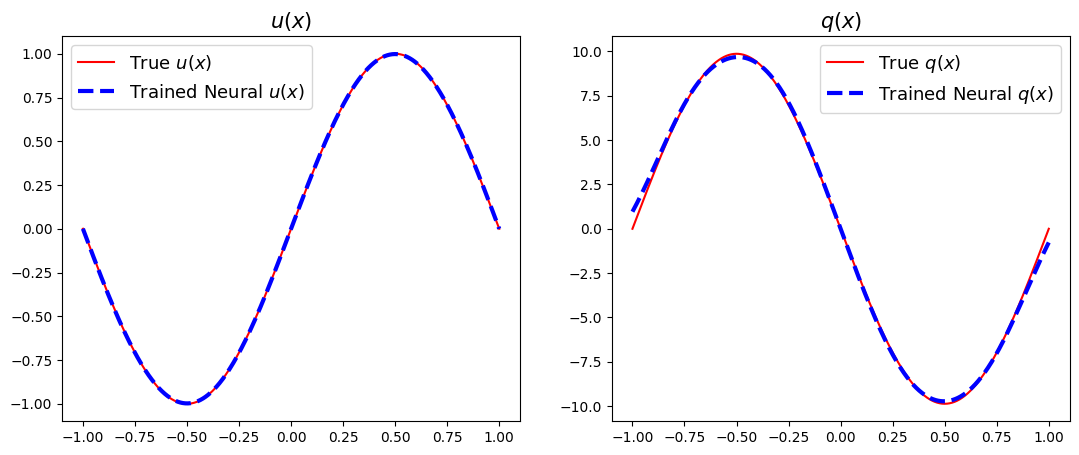

In [ ]:
figure = plt.figure(figsize=(13,5))
ax1 = figure.add_subplot(1,2,1)
ax1.plot(x.cpu().detach(), torch.sin(np.pi * x).cpu().detach(), color='r', label='True $u(x)$')
ax1.plot(x.cpu().detach(), network_u(x).cpu().detach(), color='b', linestyle='--', lw=3, label='Trained Neural $u(x)$')
ax1.legend(fontsize=13)
ax1.set_title('$u(x)$', fontsize=15)

ax2 = figure.add_subplot(1,2,2)
ax2.plot(x.cpu().detach(), -(np.pi**2)*torch.sin(np.pi * x).cpu().detach(), color='r', label='True $q(x)$')
ax2.plot(x.cpu().detach(), network_q(x).cpu().detach(), color='b', linestyle='--', lw=3, label='Trained Neural $q(x)$')
ax2.legend(fontsize=13)
ax2.set_title('$q(x)$', fontsize=15)
plt.savefig('poisson_inv', dpi=100)